# In this notebook, we create a model that predicts air quality values based on emissions.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

In [2]:
# import CSV data into dataframe
aq_with_emissions_by_county_with_na = pd.read_csv('csv_data/airquality_w_emmision_bycounty.csv')
aq_with_emissions_by_county = aq_with_emissions_by_county_with_na.dropna()
aq_with_emissions_by_county.tail()

,distance_to_nearest_major_city,distance_to_coast,Facility ID,BIOCO2,CH4,CO2,HFC,HFE,N2O,NF3,OTHER,OTHER_FULL,PFC,SF6,VERY_SHORT,CountyFips,StateFips,Average,Counts,Percent
1169,558875.469175,751266.227143,1.003700e+06,0.0000,9002.400000,305827.88000,0.0,0.0,182.37600,0.0,0.0,0.0,0.0,0.0,0.0,48501.0,48.0,7.799913,0.0,0.000000
1170,20118.185002,50257.650828,1.006065e+06,78.2750,9423.875000,25362.72500,0.0,0.0,6037.85250,0.0,0.0,0.0,0.0,0.0,0.0,6113.0,6.0,17.361437,3473037.0,4.160669
1171,102698.721456,216765.610333,1.003712e+06,148111.5125,13438.890625,759711.37875,0.0,0.0,5846.05225,0.0,0.0,0.0,0.0,0.0,0.0,38527.8,38.4,12.359189,1098232.0,0.000000
1172,61501.010585,109736.637604,1.004852e+06,0.0000,91538.625000,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,6115.0,6.0,8.900070,580532.0,1.095890
1173,217798.766156,343258.204334,1.005425e+06,0.0000,27559.778680,64701.74000,0.0,0.0,36.53480,0.0,0.0,0.0,0.0,0.0,0.0,6076.0,6.0,10.954348,1009255.0,0.000000


In [3]:
aq_with_emissions_by_county.columns.values

array(['distance_to_nearest_major_city', 'distance_to_coast',
       'Facility ID', 'BIOCO2', 'CH4', 'CO2', 'HFC', 'HFE', 'N2O', 'NF3',
       'OTHER', 'OTHER_FULL', 'PFC', 'SF6', 'VERY_SHORT', 'CountyFips',
       'StateFips', 'Average', 'Counts', 'Percent'], dtype=object)

Let's check the number of 0s in each column. I don't want to use a column with mostly 0s as a feature, so the model does not think that the presence of a 0 is indicative of air quality measures (when it is more likely a missing or unreported value)

In [4]:
# check number of 0s in each column. Don't use columns with
number_of_zeros = (aq_with_emissions_by_county['VERY_SHORT'] == 0).sum()

print(f"The number of zeros in the column is: {number_of_zeros}")

The number of zeros in the column is: 1056


Check correlations or columns with air quality average.

In [5]:
aq_vs_distance_to_nearest_major_city = aq_with_emissions_by_county['Average'].corr(aq_with_emissions_by_county['distance_to_nearest_major_city'])
aq_vs_distance_to_coast = aq_with_emissions_by_county['Average'].corr(aq_with_emissions_by_county['distance_to_coast'])

aq_vs_distance_to_nearest_major_city
aq_vs_distance_to_coast

-0.20071692505149386

In [6]:
np.random.seed(133)

def train_val_split(data):
    """ 
    Takes in a DataFrame `data` and randomly splits it into two smaller DataFrames 
    named `train` and `validation` with 80% and 20% of the data, respectively. 
    """
    
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    
    split_index = int(0.8*data_len)
    train = data.iloc[shuffled_indices[:split_index]]
    validation = data.iloc[shuffled_indices[split_index:]]
   
    return train, validation

In [7]:
# log transform averages
aq_with_emissions_by_county.loc[:, 'Log Average'] = np.log(aq_with_emissions_by_county['Average'])
# pick features
feature_columns = [0, 1, 4, 5, 8]
features = aq_with_emissions_by_county.iloc[:, feature_columns]
features.head()
# split features and labels into training and validation
aq_values =  aq_with_emissions_by_county['Log Average']

# SPLIT INTO TRAINING AND VALIDATION
train_X, val_X = train_val_split(features)
train_y, val_y = train_val_split(aq_values)

/var/folders/m8/skfw9g2x4_g4pq5cv80_g24w0000gn/T/ipykernel_2159/723761416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aq_with_emissions_by_county.loc[:, 'Log Average'] = np.log(aq_with_emissions_by_county['Average'])


### Now let's create the model and make predictions.

In [8]:
model = lm.LinearRegression()
model.fit(train_X, train_y)
y_hat = model.predict(train_X)

### get RMSE for training and validation sets

In [17]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    Input:
      predicted (1D array): Vector of predicted/fitted values
      actual (1D array): Vector of actual values
    Output:
      A float, the RMSE value.
    """
    return np.sqrt(np.mean((actual - predicted)**2))

training_RMSE = rmse(y_hat, train_y)
print(f'Training RMSE for model 1 is {training_RMSE}')

Training RMSE for model 1 is 0.3279328772777231


In [18]:
val_y_hat = model.predict(val_X)

In [19]:
val_RMSE = rmse(val_y_hat, val_y)
print(f'Test RMSE for model 1 is {val_RMSE}')

Test RMSE for model 1 is 0.3626213720047915


### Make a bar graph showing both.

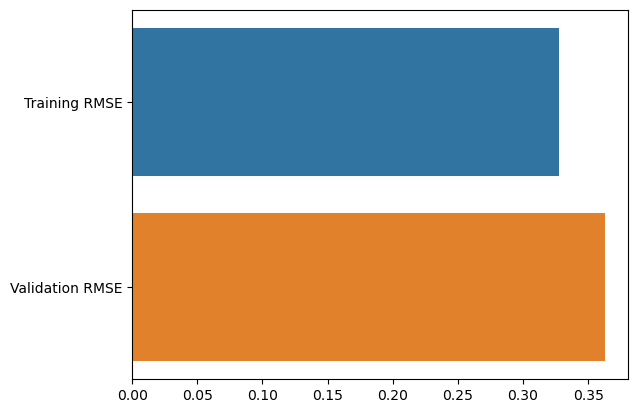

In [20]:
RMSEs = [training_RMSE, val_RMSE]
labels = ["Training RMSE", "Validation RMSE"]
sns.barplot(x= RMSEs, y= labels)
plt.show()